In [ ]:
using Plots
include("coevolution_network_base.jl")
using .CoevolutionNetworkBase

In [34]:
# Parameters
L = 60.0
dx = 0.25
x = -L/2:dx:L/2-dx
r = 3.3
M = 15
beta = 1.5
alpha = 1.0
gamma = 0.0
D = 0.02
Nh = 3 * 10^6

# Initialize viral and immune densities
viral_density = zeros(Float64, length(x))
viral_density[Int(length(x)/2)] = 100/dx
# viral_density2 = zeros(Float64, length(x))
immune_density = zeros(Float64, length(x))

# Create Population instances
population = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density, immune_density;stochastic=true)
# population2 = Population(L, dx, r, M, beta, alpha, gamma, D, Nh, viral_density2, immune_density)

# Create Network instance
migration_matrix = [0.0][:,:] # Define an appropriate migration matrix
network = Network([population], migration_matrix)

# Create Simulation instance
dt = 0.05 # Define an appropriate time step size
duration = 80.0 # Define an appropriate simulation duration
simulation = Simulation(network, dt, duration)

# Run the simulation
@time run_simulation!(simulation)


  3.262257 seconds


true

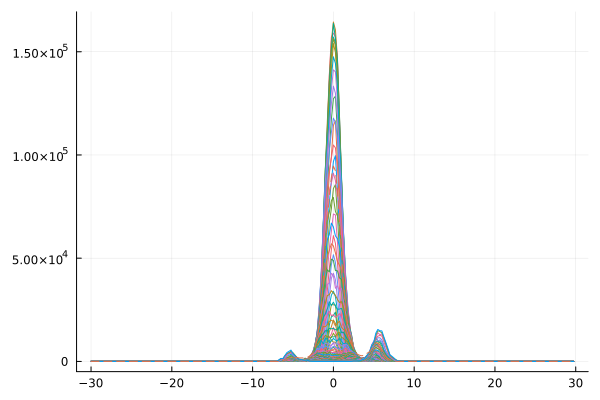

In [35]:
p = plot()
for i = 1:10:length(simulation.duration_times)
    plot!(p, population.xs, simulation.trajectory[i].populations[1].viral_density,legend=false)
end
plot!(p, population.xs, Nh .* simulation.trajectory[end].populations[1].immune_density, legend=false, linestyle=:dash)
display(p)

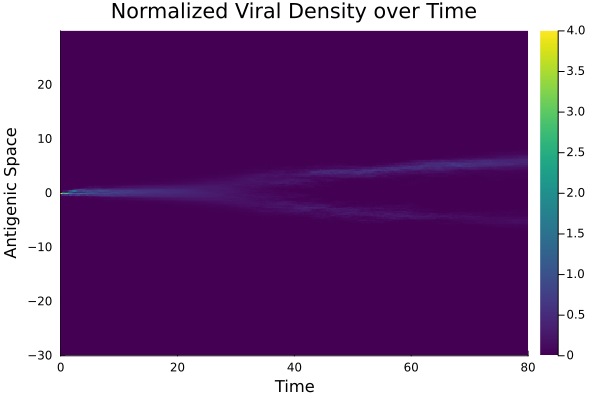

In [36]:
function plot_normalized_spacetime_density(simulation)
    # Extract relevant data
    times = simulation.duration_times # assuming this gives the array of time points
    x = simulation.trajectory[end].populations[1].xs # assuming this gives the spatial domain

    tot_infected = calculate_total_infected(simulation)
    
    z = hcat([(tot > 0 ? t.populations[1].viral_density ./ tot : zeros(size(t.populations[1].viral_density))) 
              for (t, tot) in zip(simulation.trajectory, tot_infected)]...) 
    # normalized viral densities over time or zeros if total infected is 0

    # Plotting
    heatmap(times, x, z,
        xlabel="Time",
        ylabel="Antigenic Space",
        color=:viridis, # or another color palette
        title="Normalized Viral Density over Time"
    )
end

plot_normalized_spacetime_density(simulation)


In [ ]:
plot_spacetime_density(simulation)

In [ ]:
function plot_spacetime_density(simulation)
    # Extract relevant data
    times = simulation.duration_times # assuming this gives the array of time points
    x = simulation.trajectory[end].populations[1].xs # assuming this gives the spatial domain
    
    z = hcat([network.populations[1].viral_density for network in simulation.trajectory]...) # viral densities over time
    
    # Plotting
    heatmap(times, x, z,
        xlabel="Time",
        ylabel="Antigenic Space",
        color=:viridis, # or another color palette
        title="Viral Density over Time"
    )
end

function plot_normalized_spacetime_density(simulation)
    # Extract relevant data
    times = simulation.duration_times # assuming this gives the array of time points
    x = simulation.trajectory[end].populations[1].xs # assuming this gives the spatial domain

    tot_infected = calculate_total_infected(simulation)
    
    z = hcat([(t.populations[1].viral_density ./ tot) for (t, tot) in zip(simulation.trajectory, tot_infected)]...) # normalized viral densities over time

    # Plotting
    heatmap(times, x, z,
        xlabel="Time",
        ylabel="Antigenic Space",
        color=:viridis, # or another color palette
        title="Normalized Viral Density over Time"
    )
end

In [37]:
aa = 2,3

(2, 3)

In [39]:
x, y = aa

(2, 3)

In [40]:
x

2